In [36]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [37]:
output_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis1024_LL0.05'
save_path = 'data\\nematic_analysis1024_LL0.05'
if not os.path.exists(save_path):
    os.makedirs(save_path)
path0 = os.path.join(output_path, 'analysis_zeta_0.20\\zeta_0.20_counter_0')
sys.path.append(output_path)

Nexp = 10
Nframes = 181
LX = 1024

act_list = []
act_dir_list = []

for file in os.listdir(output_path):
        activity = file.split('_')[-1]
        act_list.append(float(activity))
        act_dir_list.append(os.path.join(output_path, file))

# sort the activity list and the activity directory list
act_list, act_dir_list = zip(*sorted(zip(act_list, act_dir_list)))

Nactivity = len(act_list)
conv_list = Nactivity * [0]

conv_list[act_list.index(0.026)] = 125
conv_list[act_list.index(0.027)] = 100
conv_list[act_list.index(0.028)] = 50

Nexp, Nframes, Nactivity

(10, 181, 31)

In [47]:

conv_dict = dict(zip(act_list, conv_list))

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

defect_arr = np.nan * np.zeros((Nframes, Nactivity, Nexp))
av_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])
var_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])
count_lengths = np.zeros([Nactivity, Nexp])

for i, act in enumerate(act_list):
    
    exp_list = []
    exp_dir_list = []

    for file in os.listdir(act_dir_list[i]):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir_list[i], file))

    # sort the activity list and the activity directory list
    exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

    for exp, exp_dir in zip(exp_list, exp_dir_list):
        defect_arr[:, i, exp] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[:Nframes]


        counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[:Nframes,:]
        vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[:Nframes,:]

        idx_start_count = min(Nframes - conv_list[i], len(counts))
        av_counts[-idx_start_count:, :, i, exp] = counts[-idx_start_count:, :]
        var_counts[-idx_start_count:, :, i, exp] = vars[-idx_start_count:, :]
        count_lengths[i, exp] = idx_start_count

dens_fluc = var_counts / (np.pi * window_sizes[:, None, None] ** 2) ** 2

np.save(os.path.join(save_path, 'defect_arr.npy'), defect_arr)
np.save(os.path.join(save_path, 'av_counts.npy'), av_counts)
np.save(os.path.join(save_path, 'var_counts.npy'), var_counts)
np.save(os.path.join(save_path, 'dens_fluc.npy'), dens_fluc)


In [176]:

exp_conv_list = np.ones((Nexp, Nactivity)).astype(float)
exp_conv_list[:, 6:12] = np.nan

conv_act0021 = np.array([7])
conv_act00215 = np.array([5,6,7])
conv_act0022 = np.array([0,2,5,8])
conv_act00225 = np.array([0,1, 2, 3])
conv_act0023 = np.array([3,4])
conv_act00235 = np.array([0,2,4,6,7,8,9])

exp_conv_list[conv_act0021, 6] = 1
exp_conv_list[conv_act00215, 7] = 1
exp_conv_list[conv_act0022, 8] = 1
exp_conv_list[conv_act00225, 9] = 1
exp_conv_list[conv_act0023, 10] = 1
exp_conv_list[conv_act00235, 11] = 1

In [48]:
exp_conv_list = np.ones((Nexp, Nactivity)).astype(float)

In [98]:
# load arrays
normalize = True
save = True
act_to_remove = []

idx_exp_to_keep_list = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
idx_act_to_keep_list = np.where(~np.isin(act_list, act_to_remove))[0]
conv_list = np.delete(conv_list, np.where(np.isin(act_list, act_to_remove))[0])
                 
conv_dict = dict(zip(act_list, conv_list))
act_list = list(np.delete(act_list, np.where(np.isin(act_list, act_to_remove))[0]))
Nactivity = len(act_list)
Nexp = len(idx_exp_to_keep_list)

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

defect_arr = np.load(os.path.join(save_path, 'defect_arr.npy'))[:, :, idx_exp_to_keep_list][:, idx_act_to_keep_list, :] / LX ** 2
defect_arr_conv = defect_arr * exp_conv_list.T[np.newaxis, :Nactivity, :]

av_defects = np.zeros((Nactivity, 2)) 
defect_arr_av = np.mean(defect_arr, axis=2)
defect_arr_std = np.std(defect_arr, axis=2)

av_defects_conv = np.zeros((Nactivity, 2))
defect_arr_av_conv = np.nanmean(defect_arr_conv, axis=2)
defect_arr_std_conv = np.nanstd(defect_arr_conv, axis=2)

for i, act in enumerate(act_list):
    av_defects[i, 0] = np.mean(defect_arr_av[conv_dict[act]:, i])
    av_defects[i, 1] = np.mean(defect_arr_std[conv_dict[act]:, i]) / np.sqrt(Nframes - conv_dict[act])
    av_defects_conv[i, 0] = np.mean(defect_arr_av_conv[conv_dict[act]:, i])
    av_defects_conv[i, 1] = np.mean(defect_arr_std_conv[conv_dict[act]:, i]) 
av_defects_conv[:, 1] = av_defects_conv[:, 1] / np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity]


av_counts = np.load(os.path.join(save_path, 'av_counts.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
av_counts = av_counts * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
av_counts_av = np.nanmean(av_counts, axis=3)
av_counts_std = np.nanstd(av_counts, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

var_counts = np.load(os.path.join(save_path, 'var_counts.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
var_counts = var_counts * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
var_counts_av = np.nanmean(var_counts, axis=3)
var_counts_std = np.nanstd(var_counts, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

dens_fluc = np.load(os.path.join(save_path, 'dens_fluc.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
dens_fluc = dens_fluc * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
dens_fluc_av = np.nanmean(dens_fluc, axis=3)
dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if normalize:
    dens_fluc = dens_fluc / defect_arr[:, None, :, :] ** 2

    dens_fluc_av = np.nanmean(dens_fluc, axis=3)
    dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]
  
  #  av_density_all_windows = np.nanmean((av_counts_av - 1) / (np.pi * window_sizes[None, :, None] ** 2), axis = 1)
   # dens_fluc_av = dens_fluc_av / av_density_all_windows[:, None, :] ** 2
    #dens_fluc_std = dens_fluc_std / av_density_all_windows[:, None, :] ** 2

if save:
    np.save(os.path.join(save_path, 'av_counts_av.npy'), av_counts_av)
    np.save(os.path.join(save_path, 'av_counts_std.npy'), av_counts_std)
    np.save(os.path.join(save_path, 'var_counts_av.npy'), var_counts_av)
    np.save(os.path.join(save_path, 'var_counts_std.npy'), var_counts_std)
    np.save(os.path.join(save_path, 'dens_fluc_av.npy'), dens_fluc_av)
    np.save(os.path.join(save_path, 'dens_fluc_std.npy'), dens_fluc_std)
    np.save(os.path.join(save_path, 'av_defects.npy'), av_defects)
    np.save(os.path.join(save_path, 'av_defects_conv.npy'), av_defects_conv)


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_4072\3426214274.py:38: RuntimeWarning: Mean of empty slice
  av_counts_av = np.nanmean(av_counts, axis=3)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_4072\3426214274.py:43: RuntimeWarning: Mean of empty slice
  var_counts_av = np.nanmean(var_counts, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_4072\3426214274.py:48: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_4072\3426214274.py:54: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)


In [50]:
min_window_idx=0
first_frame_list = np.array(conv_list)
Nframes_non_nan_counts = Nframes - np.array(first_frame_list)

min_act_idx = 0


In [9]:
act_list[min_act_idx]

0.019

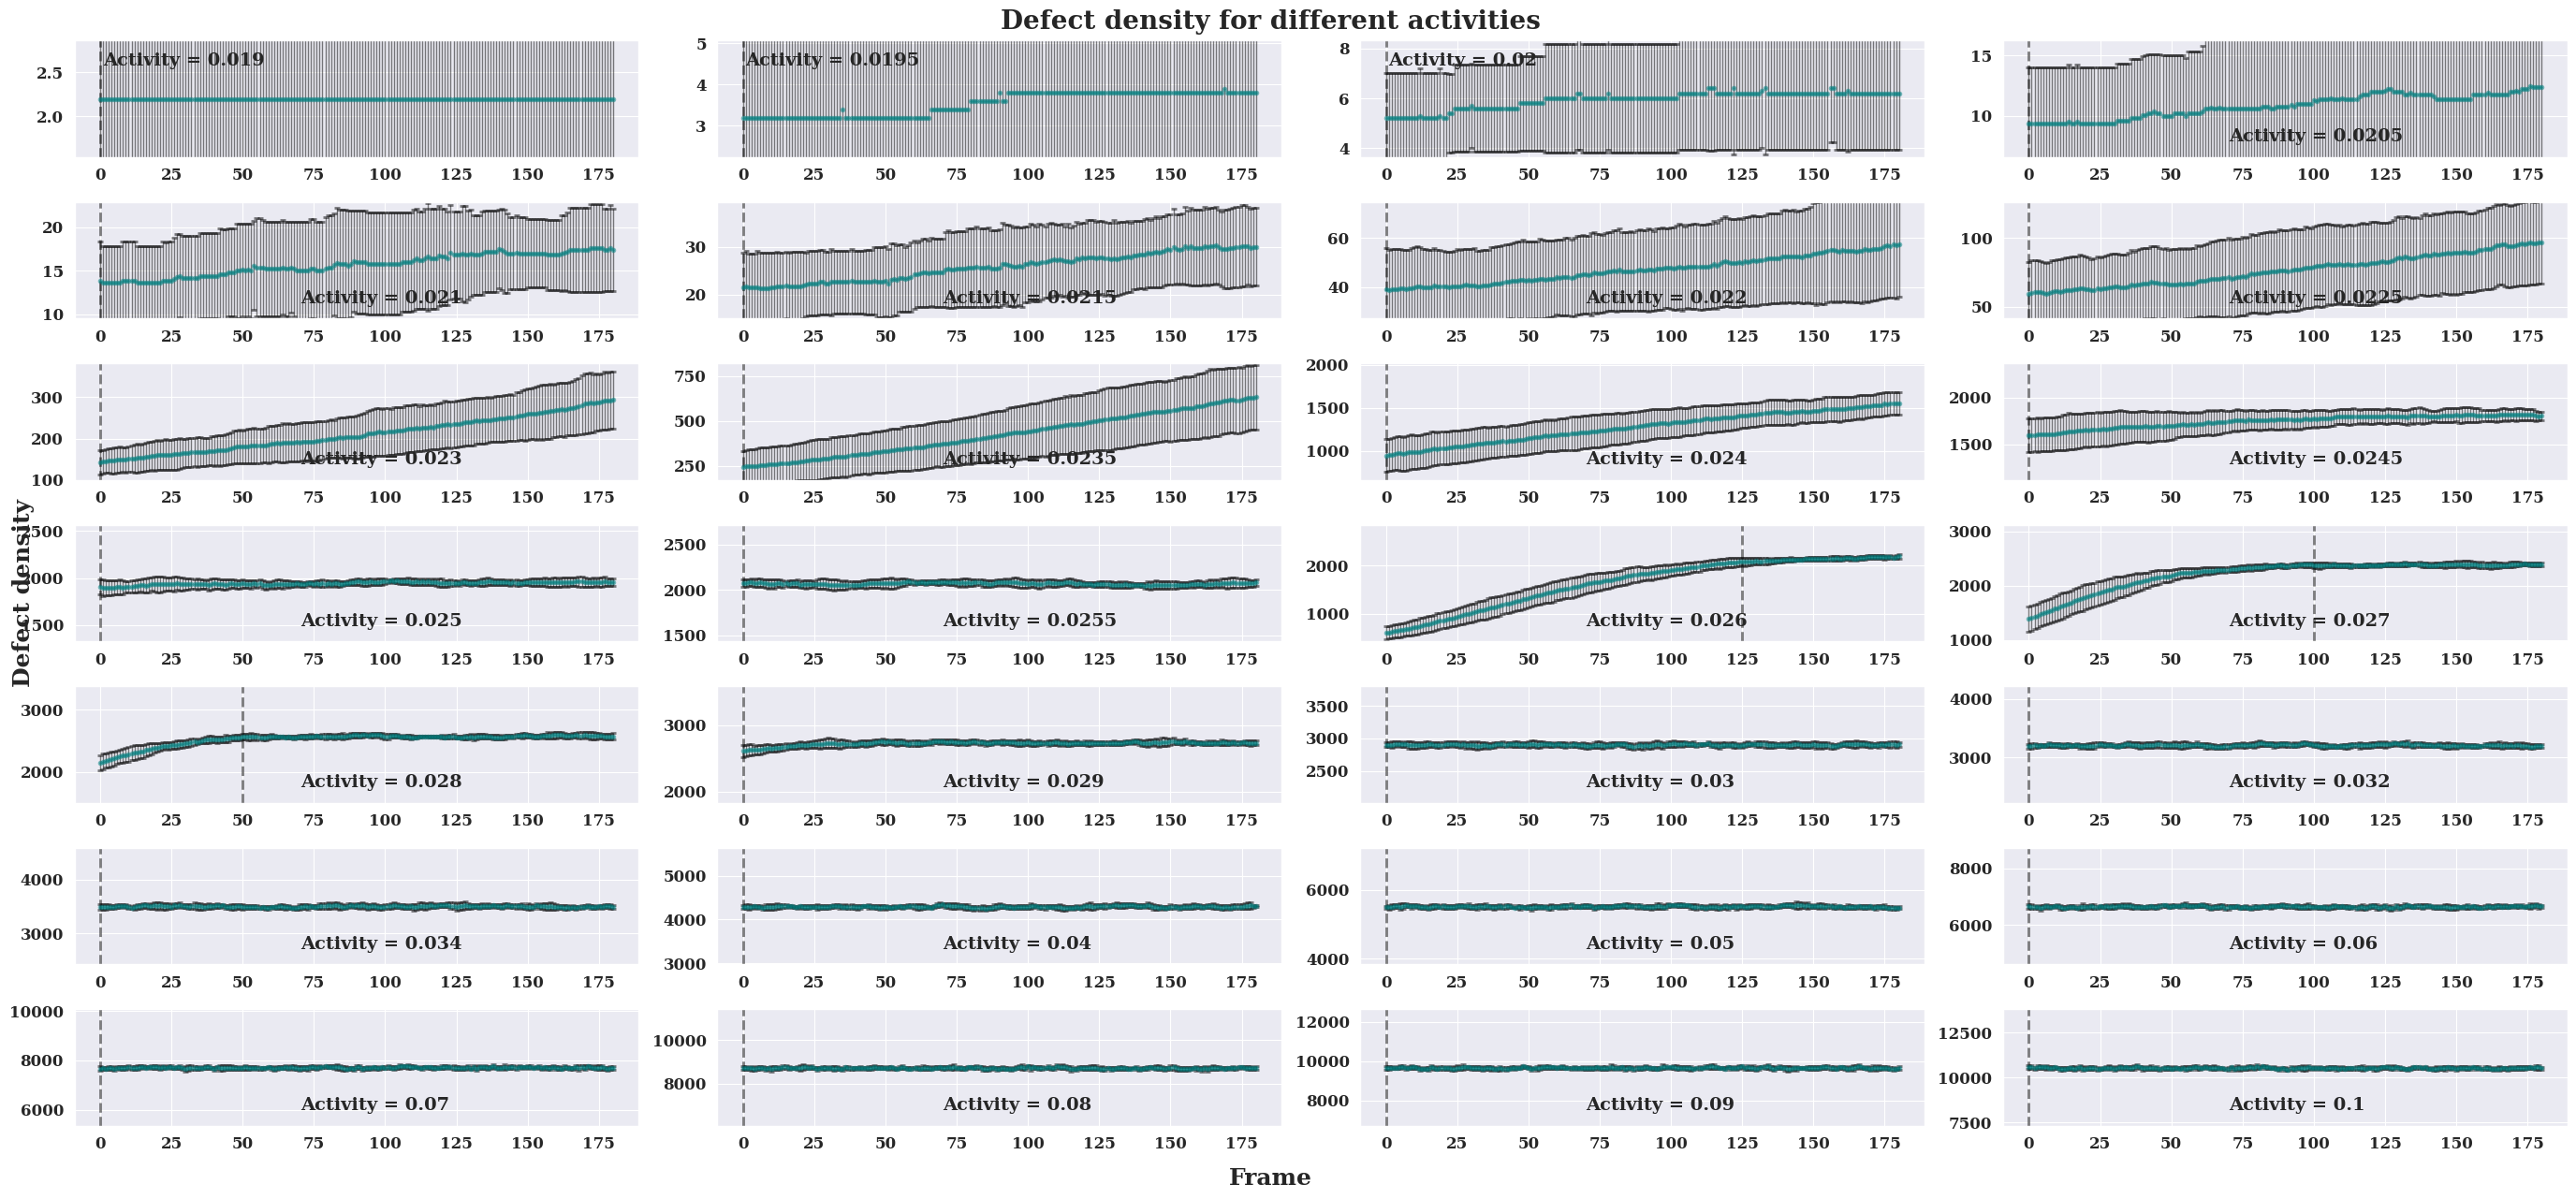

In [52]:
ncols = 4
nrows = int(np.ceil(Nactivity / ncols))
nrows = 7
fig, ax = plt.subplots(nrows = nrows, ncols = 4, figsize=(28, 13))
ax = ax.flatten()


for i, act in enumerate(act_list[min_act_idx:min_act_idx + 28]):
    act_idx = act_list.index(act)
    mini, maxi = np.nanmin(defect_arr_av[:, act_idx]) * LX ** 2, np.nanmax(defect_arr_av[:, act_idx]) * LX ** 2
    ax[i].errorbar(np.arange(Nframes), defect_arr_av_conv[:, act_idx] * LX**2, defect_arr_std_conv[:, act_idx] * LX**2, label='activity = {}'.format(act), fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='black')
    
    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylim(0.7 * mini, 1.3 * maxi)


    if i < 3:
        ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
    else:
        ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

fig.suptitle('Defect density for different activities')
fig.supxlabel('Frame')
fig.supylabel('Defect density')

#ax[-1].axis('off')
#ax[-2].axis('off')


plt.tight_layout()
plt.show()

In [95]:
var_counts[:,:,-1,-1].shape

(181, 30)

In [130]:
for act_idx in np.arange(var_counts.shape[-2]):
    for frame in np.arange(var_counts.shape[0]):
        nans = np.isnan(var_counts_av[frame, :, act_idx])
        if nans.sum() > 0 and act_list[act_idx] > 0.019:
            print("For activity {} and frame {} there are {} nan values in var_counts_av".format(act_list[act_idx], frame, nans.sum()))


For activity 0.0195 and frame 35 there are 30 nan values in var_counts_av
For activity 0.0195 and frame 36 there are 30 nan values in var_counts_av
For activity 0.0195 and frame 37 there are 30 nan values in var_counts_av
For activity 0.0195 and frame 38 there are 30 nan values in var_counts_av
For activity 0.0195 and frame 39 there are 30 nan values in var_counts_av
For activity 0.02 and frame 163 there are 30 nan values in var_counts_av
For activity 0.02 and frame 164 there are 30 nan values in var_counts_av
For activity 0.02 and frame 165 there are 30 nan values in var_counts_av
For activity 0.02 and frame 166 there are 30 nan values in var_counts_av
For activity 0.02 and frame 167 there are 30 nan values in var_counts_av
For activity 0.02 and frame 168 there are 30 nan values in var_counts_av
For activity 0.02 and frame 169 there are 30 nan values in var_counts_av
For activity 0.02 and frame 170 there are 30 nan values in var_counts_av
For activity 0.02 and frame 171 there are 30 n

In [19]:
conv_list[act_list.index(0.026)] = 125
conv_list[act_list.index(0.027)] = 100
conv_list[act_list.index(0.028)] = 50

In [62]:
del min
del max

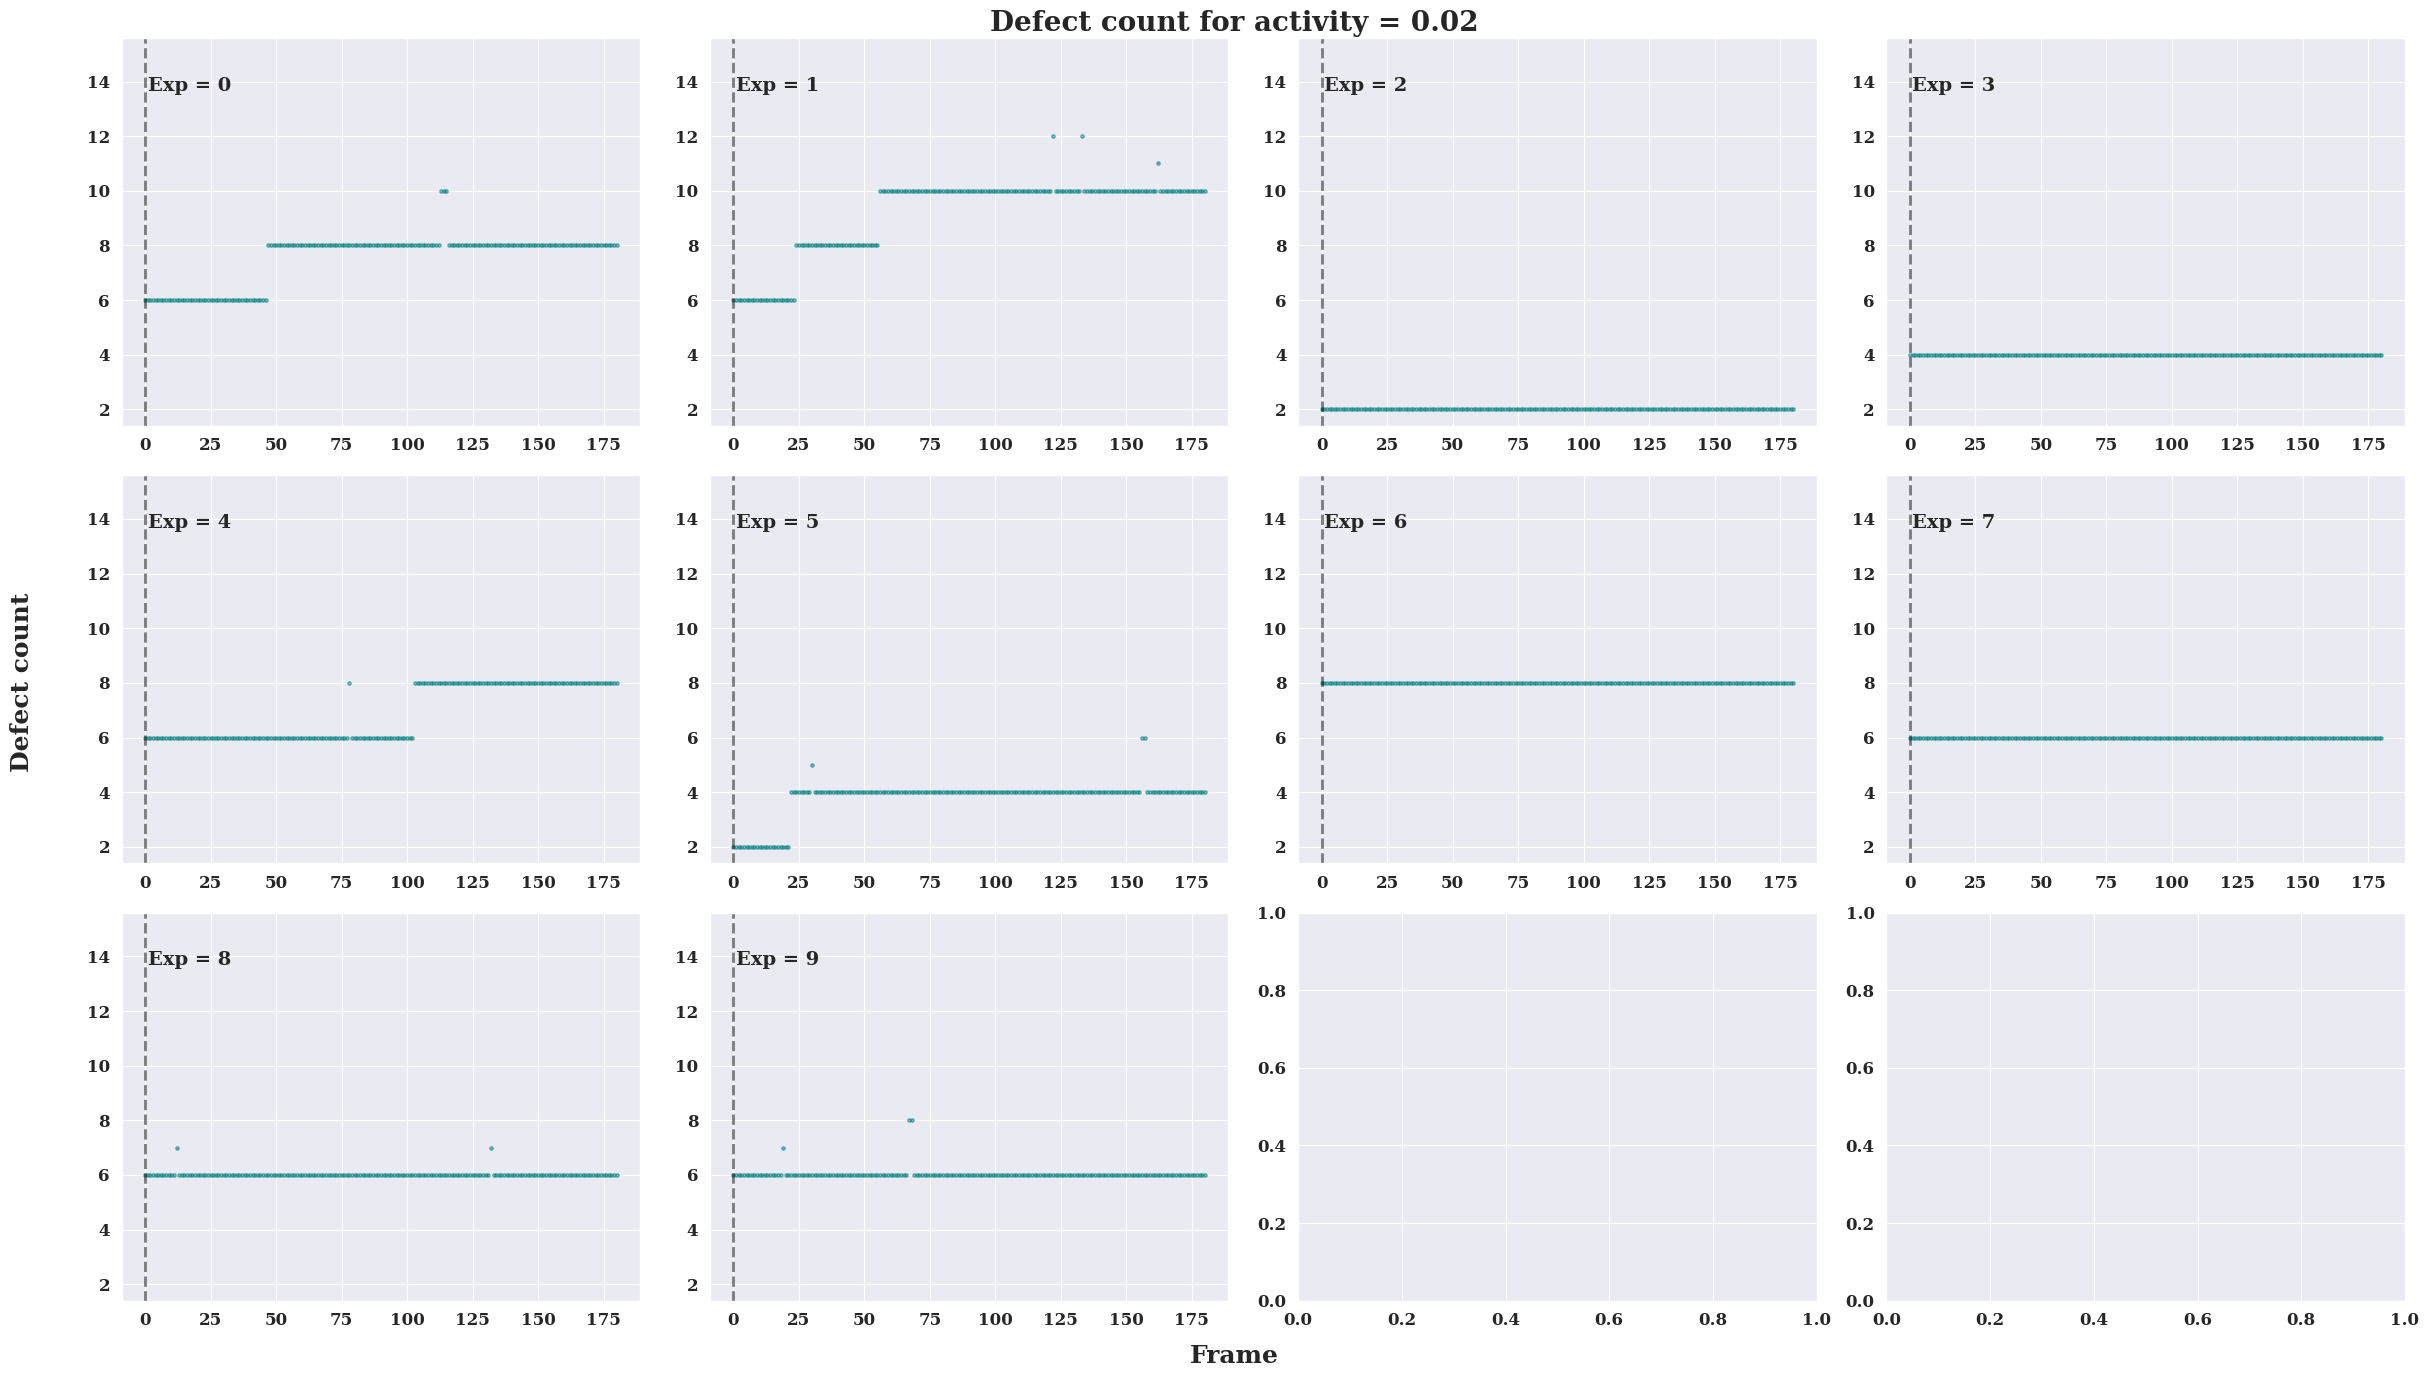

In [53]:
act_idx = 2
ncols = 4
nrows = int(np.ceil(Nactivity / ncols))
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(24, 14))
ax = ax.flatten()
mini, maxi = np.nanmin(defect_arr[:, act_idx, :]) * LX **2, np.nanmax(defect_arr[:, act_idx, : ]) * LX ** 2
for i in np.arange(Nexp):
    ax[i].plot(np.arange(Nframes), defect_arr[:, act_idx, i] * LX**2, '.', label='exp = {}'.format(i), alpha = 0.5)
    
    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)

    ax[i].set_ylim(mini * 0.7, maxi * 1.3)


    ax[i].text(0.05, 0.9, 'Exp = {}'.format(i), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')

fig.suptitle('Defect count for activity = {}'.format(act_list[act_idx]))
fig.supxlabel('Frame')
fig.supylabel('Defect count', x = -0.01)

#ax[-1].axis('off')
#ax[-2].axis('off')


plt.tight_layout()
plt.show()

In [54]:
def linear(x, a, b):
    return a * x + b
# Try fitting with other functions
def qudratic(x, a, b, c):
    return a * x**2 + b * x + c
def power(x, a, b, c, d):
    return a * x**d + b * x + c
def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c

In [55]:
# do a linear fit to the average defect density
param_guess_lin = np.array([70 * 100, 100])
param_guess_quad = np.array([70 * 100, 100, 0])
param_guess_power = np.array([7000, 2, 7100, -29])
param_guess_log = np.array([7000, 300, 30])
fit_func = log_func
fit_string = rf'$y = a x^2 + bx + c$'
fit_string = rf'$y = a \ln x + bx + c $'

param_guess = param_guess_log / LX ** 2
# fit starting with different lower activity values
for i in range(0, len(act_list) - 1):
    lin_fit = do_chi2_fit(fit_func, act_list[i:], av_defects_conv[i:, 0], av_defects_conv[i:, 1], parameter_guesses= param_guess, verbose=False)

    print("Fitting only activities >= {}".format(act_list[i]))
    Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[i:]))
    print("Ndof, chi2, pval: ", Ndof, np.round(chi2, 2), np.round(pval, 7))
print("\n\n")

 
lower_act_index = act_list.index(0.0235)

lin_fit = do_chi2_fit(fit_func, act_list[lower_act_index:], av_defects_conv[lower_act_index:, 0], av_defects_conv[lower_act_index:, 1], parameter_guesses= param_guess, verbose=False)
Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[lower_act_index:]))


Fitting only activities >= 0.019
Ndof, chi2, pval:  28 20884.99 0.0
Fitting only activities >= 0.0195
Ndof, chi2, pval:  27 11286.52 0.0
Fitting only activities >= 0.02
Ndof, chi2, pval:  26 8196.04 0.0
Fitting only activities >= 0.0205
Ndof, chi2, pval:  25 3814.27 0.0
Fitting only activities >= 0.021
Ndof, chi2, pval:  24 2994.66 0.0
Fitting only activities >= 0.0215
Ndof, chi2, pval:  23 2844.43 0.0
Fitting only activities >= 0.022
Ndof, chi2, pval:  22 2640.27 0.0
Fitting only activities >= 0.0225
Ndof, chi2, pval:  21 1876.41 0.0
Fitting only activities >= 0.023
Ndof, chi2, pval:  20 739.33 0.0
Fitting only activities >= 0.0235
Ndof, chi2, pval:  19 164.0 0.0
Fitting only activities >= 0.024
Ndof, chi2, pval:  18 94.31 0.0
Fitting only activities >= 0.0245
Ndof, chi2, pval:  17 86.98 0.0
Fitting only activities >= 0.025
Ndof, chi2, pval:  16 86.31 0.0
Fitting only activities >= 0.0255
Ndof, chi2, pval:  15 86.31 0.0
Fitting only activities >= 0.026
Ndof, chi2, pval:  14 85.68 0.0


C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


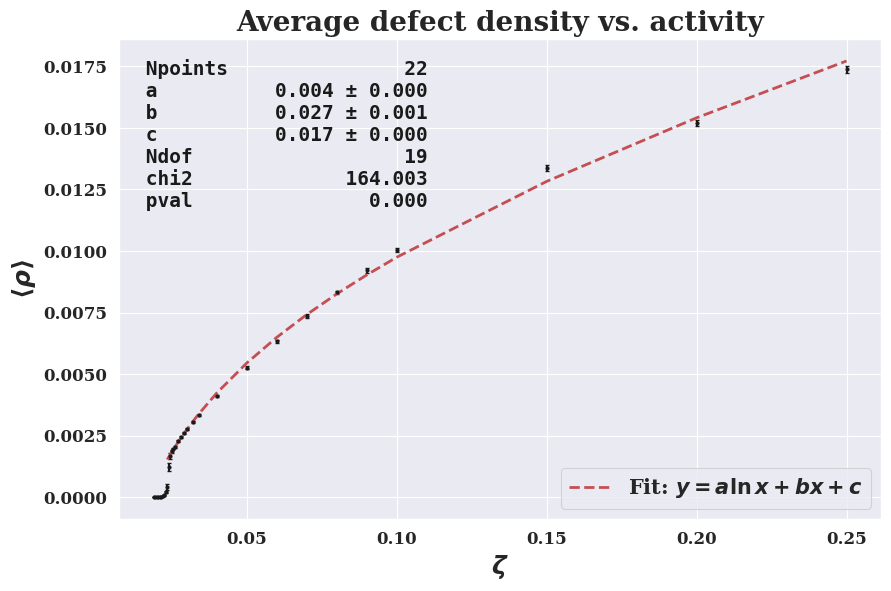

In [56]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(act_list, av_defects_conv[:, 0], yerr = av_defects_conv[:, 1], fmt = 'k.', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
ax.set_xlabel(r'$\zeta$')
ax.set_ylabel(r'$\langle \rho \rangle$')
ax.set_title('Average defect density vs. activity')

ax.plot(act_list[lower_act_index:], fit_func(np.array(act_list[lower_act_index:]), *lin_fit.values[:]), 'r--', label=rf'Fit: {fit_string}')

d = {'Fit1: y = a1x + b1': '', 'a1': [lin_fit.values['a'], lin_fit.errors['a']], 'b1': [lin_fit.values['b'],lin_fit.errors['b'] ],\
      'Fit1 Ndof1': Ndof, 'chi2val1': chi2, 'pval1': pval}

d = generate_dictionary(lin_fit, len(act_list[lower_act_index:]), chi2_suffix = None)

#d.update(d_lower)
text = nice_string_output(d, extra_spacing=4, decimals=3)
add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)
ax.legend(loc='lower right')

fig.tight_layout()
plt.show()

In [ ]:

rel_error = var_counts_std[:,min_window_idx:,:] / var_counts_av[:,min_window_idx:,:]
rel_error_av = np.nanmean(rel_error, axis=0)

rel_error_std = np.nanstd(rel_error, axis=0, ddof=1) / Nframes_non_nan_counts[np.newaxis, :]

fig, ax = plt.subplots(figsize=(9,6))
for i, act in enumerate(act_list):
    ax.errorbar(window_sizes[min_window_idx:], rel_error_av[:,i], rel_error_std[:,i], fmt='.', label = f'Act = {act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
    
ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel('Rel. error in count variance')
fig.suptitle('Rel. error in count variance vs window size')
#ax.legend(loc='upper right')

xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
fig.legend(ncol=2, fontsize = 12, bbox_to_anchor=(0.99, 0.92))
fig.tight_layout()

In [70]:
def lin_func(x, alpha, beta):
    return beta * (2 - alpha) + (2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin = np.array([0.1, 0.3])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

R = window_sizes[min_window_idx:]

fit_func = lin_func
param_guess = param_guess_lin
log_fit = True
fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
save_suffix = 'lin'


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params = np.zeros([Nframes, len(act_list), 2 * Nparams]) * np.nan
stat_arr = np.zeros([Nframes, len(act_list), 3]) * np.nan

In [58]:
act_list[min_act_idx]

0.019

In [59]:
for i,act in enumerate(act_list):
    if act < act_list[min_act_idx]:
        continue
    for frame in np.arange(first_frame_list[i], Nframes):
        count_var_av = var_counts_av[frame, min_window_idx:, i]
        count_var_std = var_counts_std[frame, min_window_idx:, i]
    if np.isnan(count_var_av).sum() > 0:
            continue
    zero_mask = count_var_av > 0
    count_var_av = count_var_av[zero_mask]
    count_var_std = count_var_std[zero_mask]
    
    if 0 < len(count_var_av) < 30:
        print("Fitting for activity {} and frame {}".format(act, frame))
        print(len(count_var_av))
        print(count_var_av)

Fitting for activity 0.0205 and frame 180
23
[0.03968 0.03968 0.03968 0.03968 0.03968 0.04762 0.06277 0.06277 0.08658
 0.10779 0.10779 0.10779 0.10779 0.10779 0.10779 0.10779 0.19625 0.24387
 0.19322 0.21934 0.21934 0.27388 0.28369]
Fitting for activity 0.021 and frame 180
19
[0.05152 0.05152 0.05152 0.05152 0.05152 0.05152 0.08114 0.10943 0.17768
 0.17768 0.24805 0.33694 0.33694 0.47177 0.65915 0.68956 0.79327 0.93853
 1.09223]


In [71]:
for i, act in enumerate(act_list):  
    if act < act_list[min_act_idx]:
        continue
    for frame in np.arange(first_frame_list[i], Nframes):
        count_var_av = var_counts_av[frame, min_window_idx:, i]
        count_var_std = var_counts_std[frame, min_window_idx:, i]
        if np.isnan(count_var_av).sum() > 0 or np.isnan(count_var_std).sum() > 0:
            continue

        zero_mask = count_var_av > 0
        if len(count_var_av[zero_mask]) < 10:
            continue

        if log_fit:
            try:
              #  with warnings.catch_warnings():
               #     warnings.simplefilter("ignore", category=np.runtimewarning)
                x = np.log(R[zero_mask])
                y = np.log(count_var_av[zero_mask])
                yerr = count_var_std[zero_mask] / count_var_av[zero_mask]
            except:
                print("Error in log for activity = ", act)
                continue
        else:
            x = R[zero_mask]
            y = count_var_av[zero_mask]
            yerr = count_var_std[zero_mask]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

        Ndof, chi2, prop = get_statistics_from_fit(fit, len(R[zero_mask]), subtract_1dof_for_binning = False)
 
        fit_params[frame, i, :Nparams] = fit.values[:]
        fit_params[frame, i, Nparams:] = fit.errors[:]
        stat_arr[frame, i, :] = Ndof, chi2, prop

print("Non-converged fits: ", np.nansum((stat_arr[:, :, -1] < 0.05)))

# save
np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}.npy'), fit_params)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}.npy'), stat_arr)

Non-converged fits:  6


In [72]:
count_var_av

array([   1.74874,    2.1637 ,    2.69538,    3.34805,    4.2795 ,
          5.53606,    7.11578,    9.02378,   11.56992,   14.73102,
         19.35824,   24.87359,   32.31155,   42.02864,   55.13857,
         72.12796,   93.84573,  122.548  ,  160.01818,  210.65706,
        276.26308,  362.04079,  476.64933,  627.53699,  820.92507,
       1066.69764, 1381.4119 , 1787.13583, 2283.54097, 2905.80079])

In [73]:
fit_params[100, :, 0]

array([     nan,      nan,  1.1054 ,  1.38766,  0.01499,  0.22057,
        0.08397,  0.0534 , -0.47035, -0.59811, -0.21124, -0.05879,
        0.08588,  0.04279,      nan,  0.07265,  0.1066 ,  0.1442 ,
        0.10173,  0.17121,  0.11156,  0.13216,  0.16685,  0.15999,
        0.17366,  0.19933,  0.15917,  0.15657,  0.09104,  0.03989,
       -0.22365])

c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


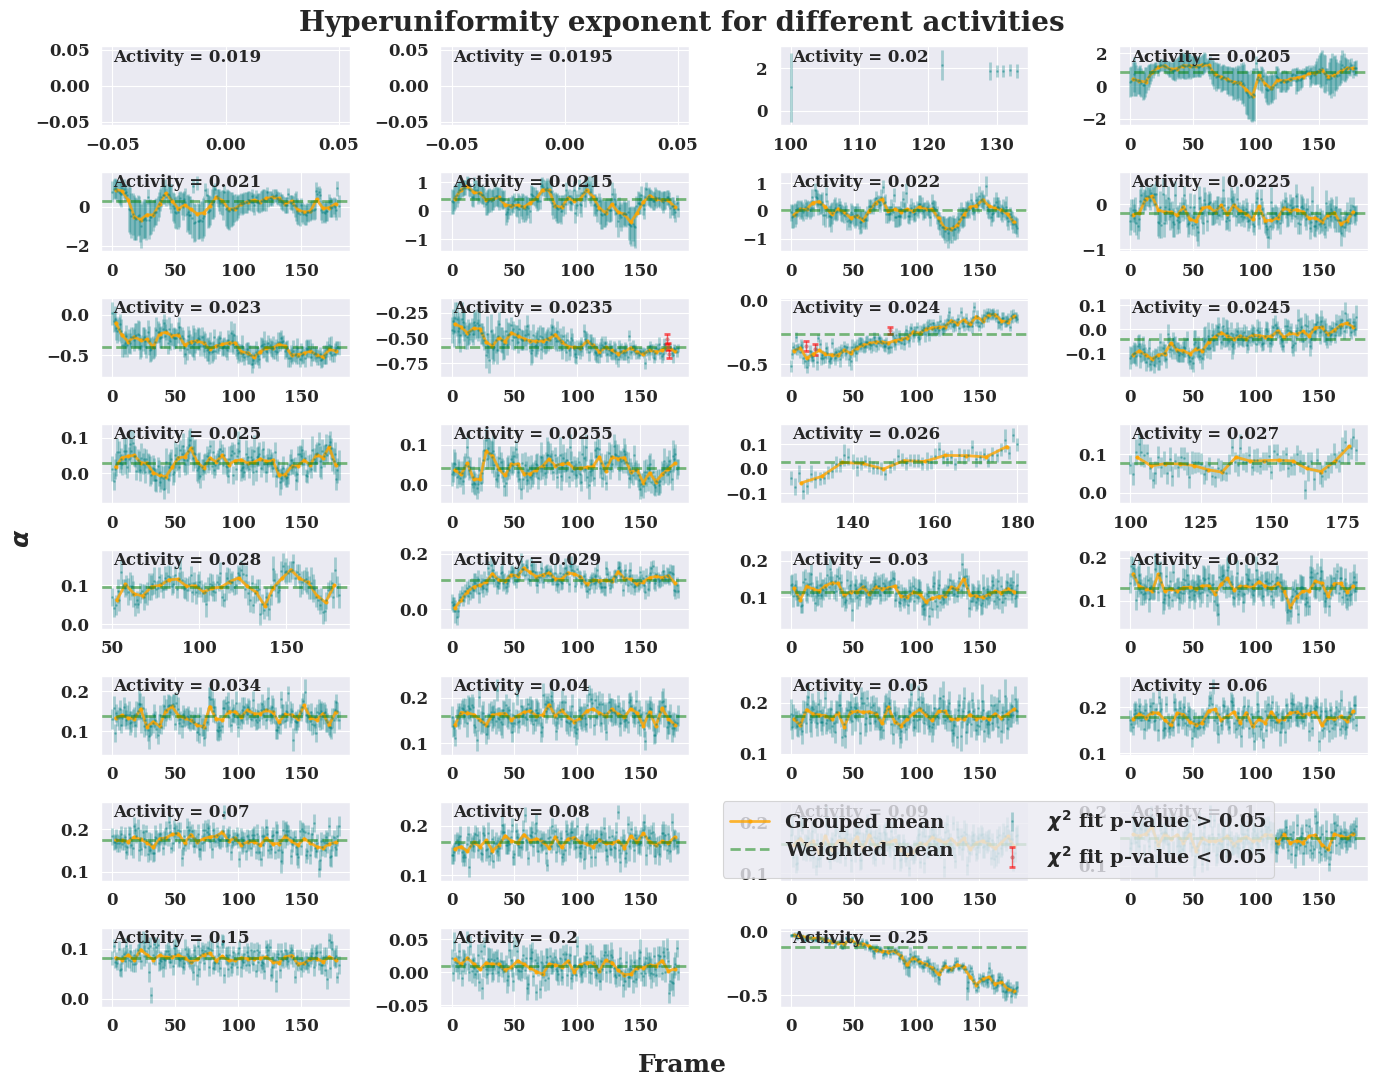

In [74]:
fig, ax = plt.subplots(nrows = 8, ncols = 4, figsize=(14, 11))

ax = ax.flatten()
Ngroup = 5

for i, act in enumerate(act_list[min_act_idx:]):
    act_idx = act_list.index(act)
    
    if i == 0:
        label1 = rf'$\chi^2$ fit p-value > 0.05'
        label2 = rf'$\chi^2$ fit p-value < 0.05'
        label3 = 'Weighted mean'
        label4 = 'Grouped mean'
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None

    p_mask = stat_arr[first_frame_list[act_idx]:, act_idx, 2] > 0.05

    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[p_mask], \
                   fit_params[first_frame_list[act_idx]:,act_idx,0][p_mask], \
                    fit_params[first_frame_list[act_idx]:,act_idx,Nparams][p_mask], \
                       fmt='.', \
                   alpha = 0.3, markersize=2, label = label1)# ecolor='black')capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, 
    
    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[~p_mask], \
                     fit_params[first_frame_list[act_idx]:,act_idx,0][~p_mask], \
                      fit_params[first_frame_list[act_idx]:,act_idx,Nparams][~p_mask], \
                        fmt='r.', \
                     capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.6, markersize=2, ecolor='red', label = label2)

    x = fit_params[first_frame_list[act_idx]:, act_idx, 0]

    max_idx = len(x) - len(x) % Ngroup 
    # group the data and calculate the weighted mean and error on mean
    x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
    dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
    x_frames = np.arange(first_frame_list[act_idx], first_frame_list[act_idx] + max_idx, Ngroup) + Ngroup / 2

    # plot x_group and dx_group
    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
    if 0:
        ax[i].errorbar(x_frames, \
                    x_group, \
                        dx_group, \
                        fmt='.', \
                    alpha = 0.5, markersize=4, ecolor='orange')


    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
    #ax[i].axhline(mean, color='orange', linestyle='-', alpha=0.5, lw = 2, label = label3)
    

    # calc and plot weighted mean and error on mean for all frames and activities
    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, fit_params[first_frame_list[i]:, act_idx, Nparams])
    ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
    
    # plot vertical lines to indicate the start of the averaging
  #  ax[i].axhline(0, color='black', linestyle='--', alpha=0.5)
    #ax[i].set_ylim(np.min(defect_arr_av[:,i])/2, np.max(defect_arr_av[:, i]) + 2  * np.max(defect_arr_std[:, i]))
    ax[i].text(0.05, 0.97, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=12, verticalalignment='top')
    if 0:
        if i < 3:
            ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
        else:
            ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

#ax[-2].axis('off')
ax[-1].axis('off')

fig.suptitle('Hyperuniformity exponent for different activities')
fig.supxlabel('Frame')
fig.supylabel(rf'$\alpha$')
fig.legend(ncol=2, fontsize = 14,bbox_to_anchor=(0.93, 0.27))

plt.tight_layout()
plt.show()

In [118]:
min_window_idx = 2

In [119]:
def lin_func_dens(x, alpha, beta):
    return beta * (- 2 - alpha) + (- 2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin_dens = np.array([0.1, 100])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

R = window_sizes[min_window_idx:]

fit_func = lin_func_dens
param_guess = param_guess_lin_dens
log_fit = True
fit_string = rf'$y = -\beta(2+\alpha) - (2+\alpha)x$'
save_suffix = 'lin'


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params_time_av = np.zeros([len(act_list), 2 * Nparams]) * np.nan
stat_arr_time_av = np.zeros([len(act_list), 3]) * np.nan




In [122]:
Nparams

2

[     nan      nan      nan      nan      nan      nan      nan -0.16134
 -0.39015 -0.52307 -0.35682 -0.07212  0.02489  0.03977  0.01397  0.07603
  0.09103  0.09912  0.11304  0.1275   0.13273  0.15375  0.16303  0.16427
  0.15765  0.15042  0.14207  0.1335   0.06281 -0.00803 -0.26453]
[    nan     nan     nan     nan     nan     nan     nan 0.03977 0.
 0.      0.      0.      0.01111 0.      0.50296 0.00813 0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.     ]


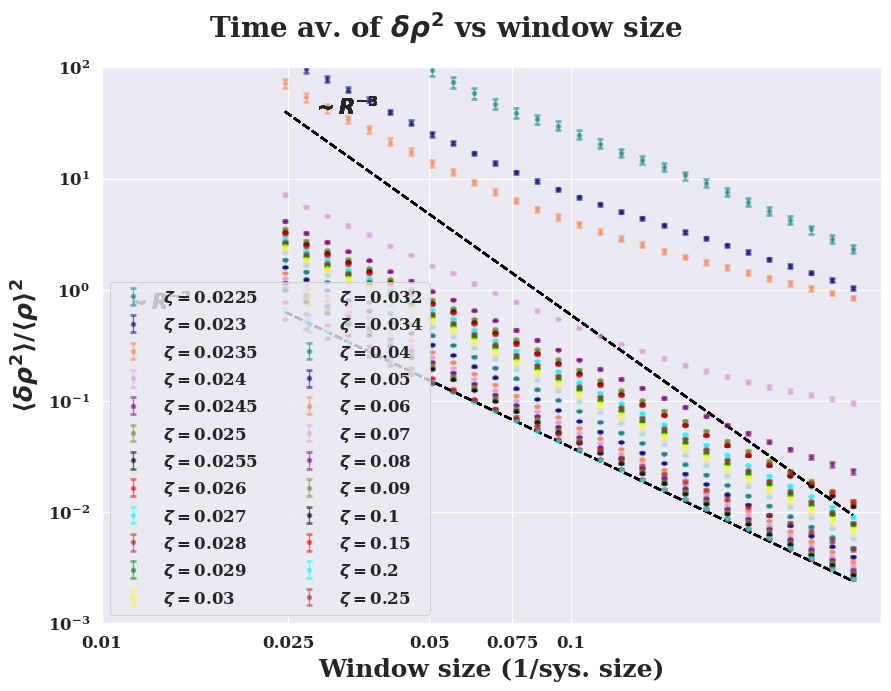

In [120]:

fig, ax = plt.subplots(figsize=(9,7))
for i, act in enumerate(act_list):
    if act < 0.0225:
        continue

    frames_av_dens = np.mean(dens_fluc_av[first_frame_list[i]:, min_window_idx:,i], axis = 0)
    frames_av_dens_std = np.mean(dens_fluc_std[first_frame_list[i]:, min_window_idx:,i], axis = 0) \
                      / np.sqrt(Nframes_non_nan_counts[i])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
        fit = do_chi2_fit(fit_func, np.log(R), np.log(frames_av_dens), frames_av_dens_std / frames_av_dens, param_guess, verbose = False)

    Ndof, chi2, prop = get_statistics_from_fit(fit, len(R), subtract_1dof_for_binning = False)

    fit_params_time_av[i, :Nparams] = fit.values[:]
    fit_params_time_av[i, Nparams:] = fit.errors[:]
    stat_arr_time_av[i, :] = Ndof, chi2, prop


    ax.errorbar(window_sizes[min_window_idx:], frames_av_dens, \
                frames_av_dens_std, fmt='.', label = fr'$\zeta = ${act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

    ax.plot(window_sizes[min_window_idx:], 25 / window_sizes[min_window_idx:] ** (2), '--', color='black', alpha=0.5, lw = 1.5)
    ax.text(0.03, 0.6, r'$\sim R^{-2}$', fontsize=15, transform=ax.transAxes, verticalalignment='top', fontweight='normal')

    ax.plot(window_sizes[min_window_idx:], 10000/ window_sizes[min_window_idx:] ** (3), '--', color='black', alpha=0.5, lw = 1.5)
    ax.text(0.27, 0.95, r'$\sim R^{-3}$', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight='normal')

ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel(rf'$\langle \delta \rho ^2 \rangle /  \langle \rho \rangle ^2$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom=0.001, top = 100)
xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
ax.legend(ncol=2, fontsize = 12, loc = 'lower left') 

fig.suptitle(rf'Time av. of $ \delta \rho^2$ vs window size')
fig.tight_layout()

# save
np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}_time_av.npy'), fit_params_time_av)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}_time_av.npy'), stat_arr_time_av)

print(fit_params_time_av[:,0])
print(stat_arr_time_av[:,-1])

In [79]:
p_mask.shape

(181,)

In [90]:
window_sizes[-8] / LX

0.048524188026556024

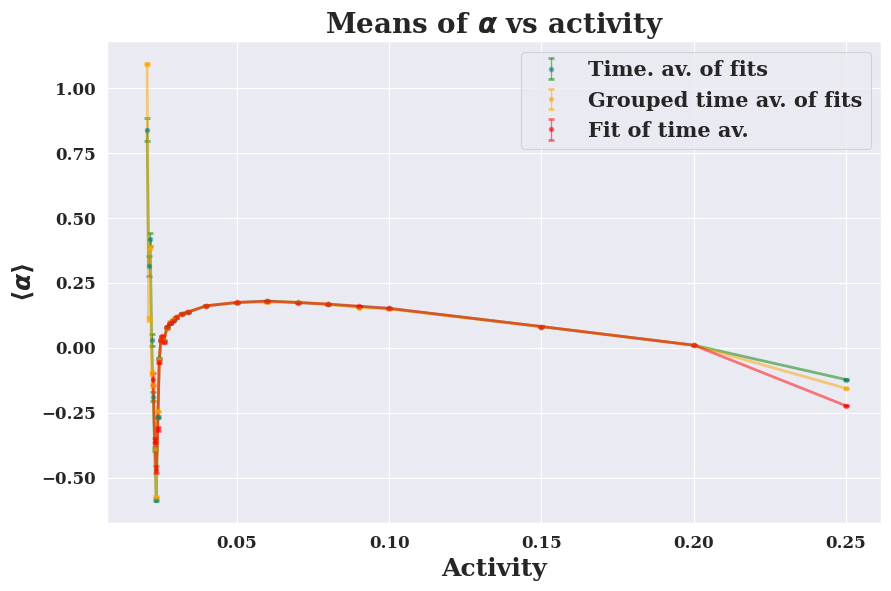

In [113]:
# calc weighted mean and error on mean for all frames and activities

Ngroup = 5
group = True
weighted_means_list = []
weighted_errs_list = []
weighted_means_group_list = []
weighted_errs_group_list = []

for i, act in enumerate(act_list):
        if act < act_list[min_act_idx]:
               continue
        
        if group:
                x = fit_params[first_frame_list[i]:, i, 0]

                max_idx = len(x) - len(x) % Ngroup
                # group the data and calculate the weighted mean and error on mean
                x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
                dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)

                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
                weighted_means_group_list.append(mean)
                weighted_errs_group_list.append(err)
      
        if 1:
             #   p_mask = (0.05 < stat_arr[first_frame_list[i]:, i, 2])  
                x = fit_params[:, i, 0][p_mask][first_frame_list[i]:]
                dx = fit_params[:, i, Nparams][p_mask][first_frame_list[i]:]

        try:
                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, dx)
                weighted_means_list.append(mean)
                weighted_errs_list.append(err)
        except:
                print("No fits for activity = {}".format(act))
                weighted_means_list.append(np.nan)
                weighted_errs_list.append(np.nan)


fig2, ax2 = plt.subplots(figsize=(9,6))
ax2.errorbar(act_list[min_act_idx:], weighted_means_list, weighted_errs_list, fmt='.', label = 'Time. av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='green')
ax2.plot(act_list[min_act_idx:], weighted_means_list, '-', color='green', alpha=0.5, )
ax2.errorbar(act_list[min_act_idx:], weighted_means_group_list, weighted_errs_group_list, fmt='.', label = 'Grouped time av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='orange', color = 'orange')
ax2.plot(act_list[min_act_idx:],weighted_means_group_list,  '-',color='orange', alpha=0.5)
ax2.errorbar(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], fit_params_time_av[min_act_idx:,Nparams], fmt='.', label = 'Fit of time av.', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='red', color = 'red'
             )
ax2.plot(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], '-', color='red', alpha=0.5)

ax2.set_xlabel('Activity')
ax2.set_ylabel(rf'$\langle\alpha \rangle$')
ax2.set_title(rf'Means of $\alpha $ vs activity')
ax2.legend()
fig2.tight_layout()

In [180]:
act_list[6]

0.0195

In [222]:
min_window_cutoff_idx

5

In [95]:
cutoff = 0
for j, windows in enumerate(window_sizes):
    norm = 1 # xi_av[j, act_max_idx]
    
    print("\nWindow size: ", windows)
    print(xi_av[j, cutoff:]/ norm)
    print(xi_av_old[j, cutoff:]/ norm)
    print(act_list[cutoff + np.argmax(xi_av[j,cutoff:] / norm)])
    print(act_list[cutoff + np.argmax(xi_av_old[j,cutoff:] / norm)])


Window size:  5.119999999999999
[   0.         0.      2819.66052 2896.27495 3226.25866 3082.96674
 2251.75755 1061.77184  223.31456  125.72479   12.32535    7.15939
    6.04457    5.65364    5.55603    4.95916    4.6584     4.44312
    4.22913    3.92058    3.68889    3.20281    2.70979    2.37725
    2.11649    1.90308    1.74677    1.60961    1.21041    1.02938
    0.82044]
[   0.         0.         0.51808    2.82411 5213.87312  162.86093
  144.94917  112.80641   44.2356    23.37936   10.63521    8.26422
    7.54249    7.08673    6.9333     6.21795    5.80931    5.51699
    5.21725    4.76641    4.4263     3.71301    2.99709    2.54184
    2.20296    1.94665    1.75793    1.60105    1.16025    0.96769
    0.76651]
0.021
0.021

Window size:  5.677185230724498
[   0.         0.      1865.28162 2269.7489  2150.19329 2188.89049
 1562.18043  787.69081  161.96169   92.93309    9.14764    5.31944
    4.49932    4.20866    4.12987    3.69752    3.47093    3.3087
    3.15107    2.92481    

In [226]:
act_list[act_max_idx]

0.021

In [88]:
window_sizes[-10] / window_sizes[-1]

0.394668141252916

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_4072\1642619186.py:7: RuntimeWarning: Mean of empty slice
  dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


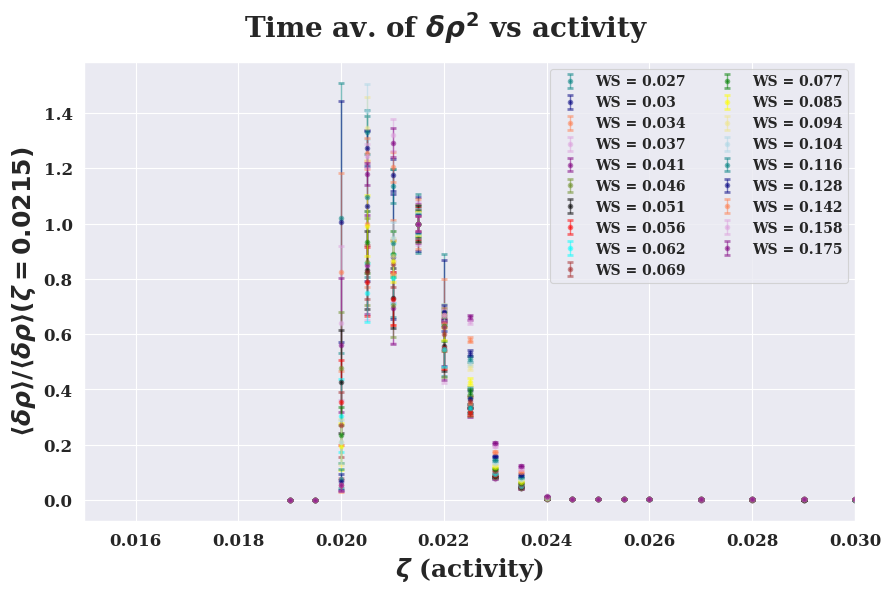

In [94]:
dens_fluc2 = np.load(os.path.join(save_path, 'dens_fluc.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
dens_fluc2 = dens_fluc2 * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]

av_dens_arr = defect_arr
dens_fluc2 = dens_fluc2 / av_dens_arr[:, None, :, :] ** 2

dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
dens_fluc_std2 = np.nanstd(dens_fluc2, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if 0:
    av_density_all_windows2 = av_defects_conv[:, 0] 
    dens_fluc_av2 = dens_fluc_av2 / av_density_all_windows2[:, None, :] ** 2
    dens_fluc_std2 = dens_fluc_std2 / av_density_all_windows2[:, None, :] ** 2

logplot = False

xi_av_old = np.nanmean(dens_fluc_av, axis = 0)
xi_std_old = np.nanstd(dens_fluc_av, axis = 0, ddof=1) / np.sqrt(Nframes_non_nan_counts[np.newaxis, :])

xi_av =  np.nanmean(dens_fluc_av2, axis = 0) #* window_sizes[:, None]**2  #** 2
xi_std = np.nanstd(dens_fluc_av2, axis = 0, ddof=1) / np.sqrt(Nframes_non_nan_counts[np.newaxis, :]) #* window_sizes[:, None]**2 #** 2

fig, ax = plt.subplots(figsize=(9,6))

min_act_cutoff_idx = 0
min_window_cutoff_idx = 3
max_window_cutoff_idx = -8
act_max_idx = act_list.index(0.0215)

for j, window in enumerate(window_sizes[min_window_cutoff_idx:]):
        if window >= window_sizes[max_window_cutoff_idx]:
             continue
        norm = xi_av[j + min_window_cutoff_idx, act_max_idx]
        if j % 1 == 0: #in [1,2,3,4,5,6,7]:
            ax.errorbar(act_list[min_act_cutoff_idx:], xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm,\
                            xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm, label=f'WS = {np.round(window / 256,3)}', fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

ax.set_xlabel(rf'$\zeta$ (activity)')
ax.set_ylabel(rf'$\langle \delta \rho \rangle / \langle \delta \rho \rangle (\zeta = {act_list[act_max_idx]}) $')
ax.set_xlim(0.015,0.03)

if logplot:
  #  ax.set_yscale('log')
    ax.set_xscale('log')

#add legend above the plot in 3 rows
ax.legend(loc='upper right', ncol=2, fontsize = 10,)
fig.suptitle(rf'Time av. of $\delta \rho ^2$ vs activity', fontsize=20)
fig.tight_layout()
plt.show()

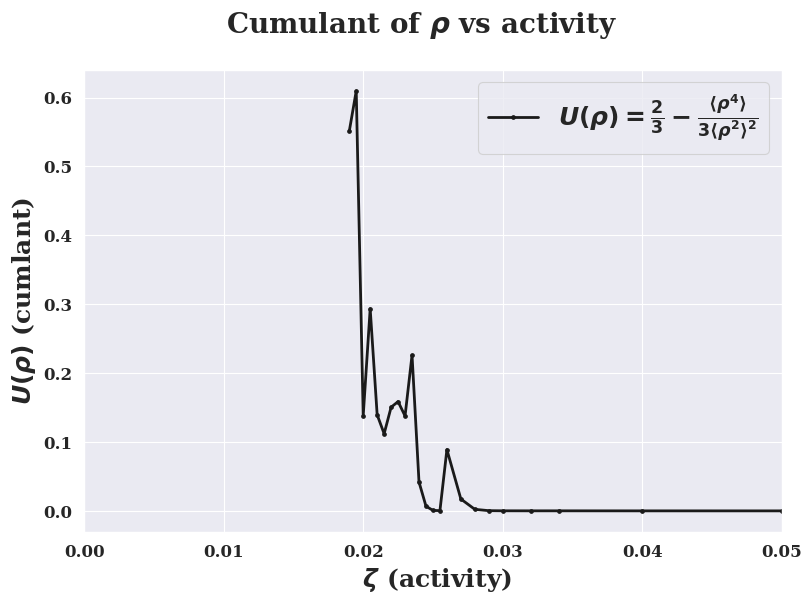

In [93]:
binder_tot = 1 - np.nanmean(np.nanmean(defect_arr[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr[:,:,:] ** 2, axis = -1), axis = 0) ** 2)


# save
np.save(os.path.join(save_path, f'binder_cumulants.npy'), binder_tot)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(act_list, 2/3 - binder_tot, 'k.-', label=r'$U(\rho) = \frac{2}{3} - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$')

ax.set_xlim(0, 0.05)
ax.set_xlabel(r' $\zeta$ (activity)')
ax.set_ylabel(r'$U(\rho)$ (cumlant)')
ax.legend(loc='upper right', ncol=2, fontsize = 18)
fig.suptitle(rf'Cumulant of $\rho$ vs activity', fontsize=20)

plt.show()